Index(['mode', 'ox/red', 'error', 'control changes', 'counter inc.', 'Ns',
       'time/s', 'control/mA', 'Ewe/V', 'I/mA', 'dQ/mA.h', 'I Range', 'P/W',
       'Unnamed: 13'],
      dtype='object')
14


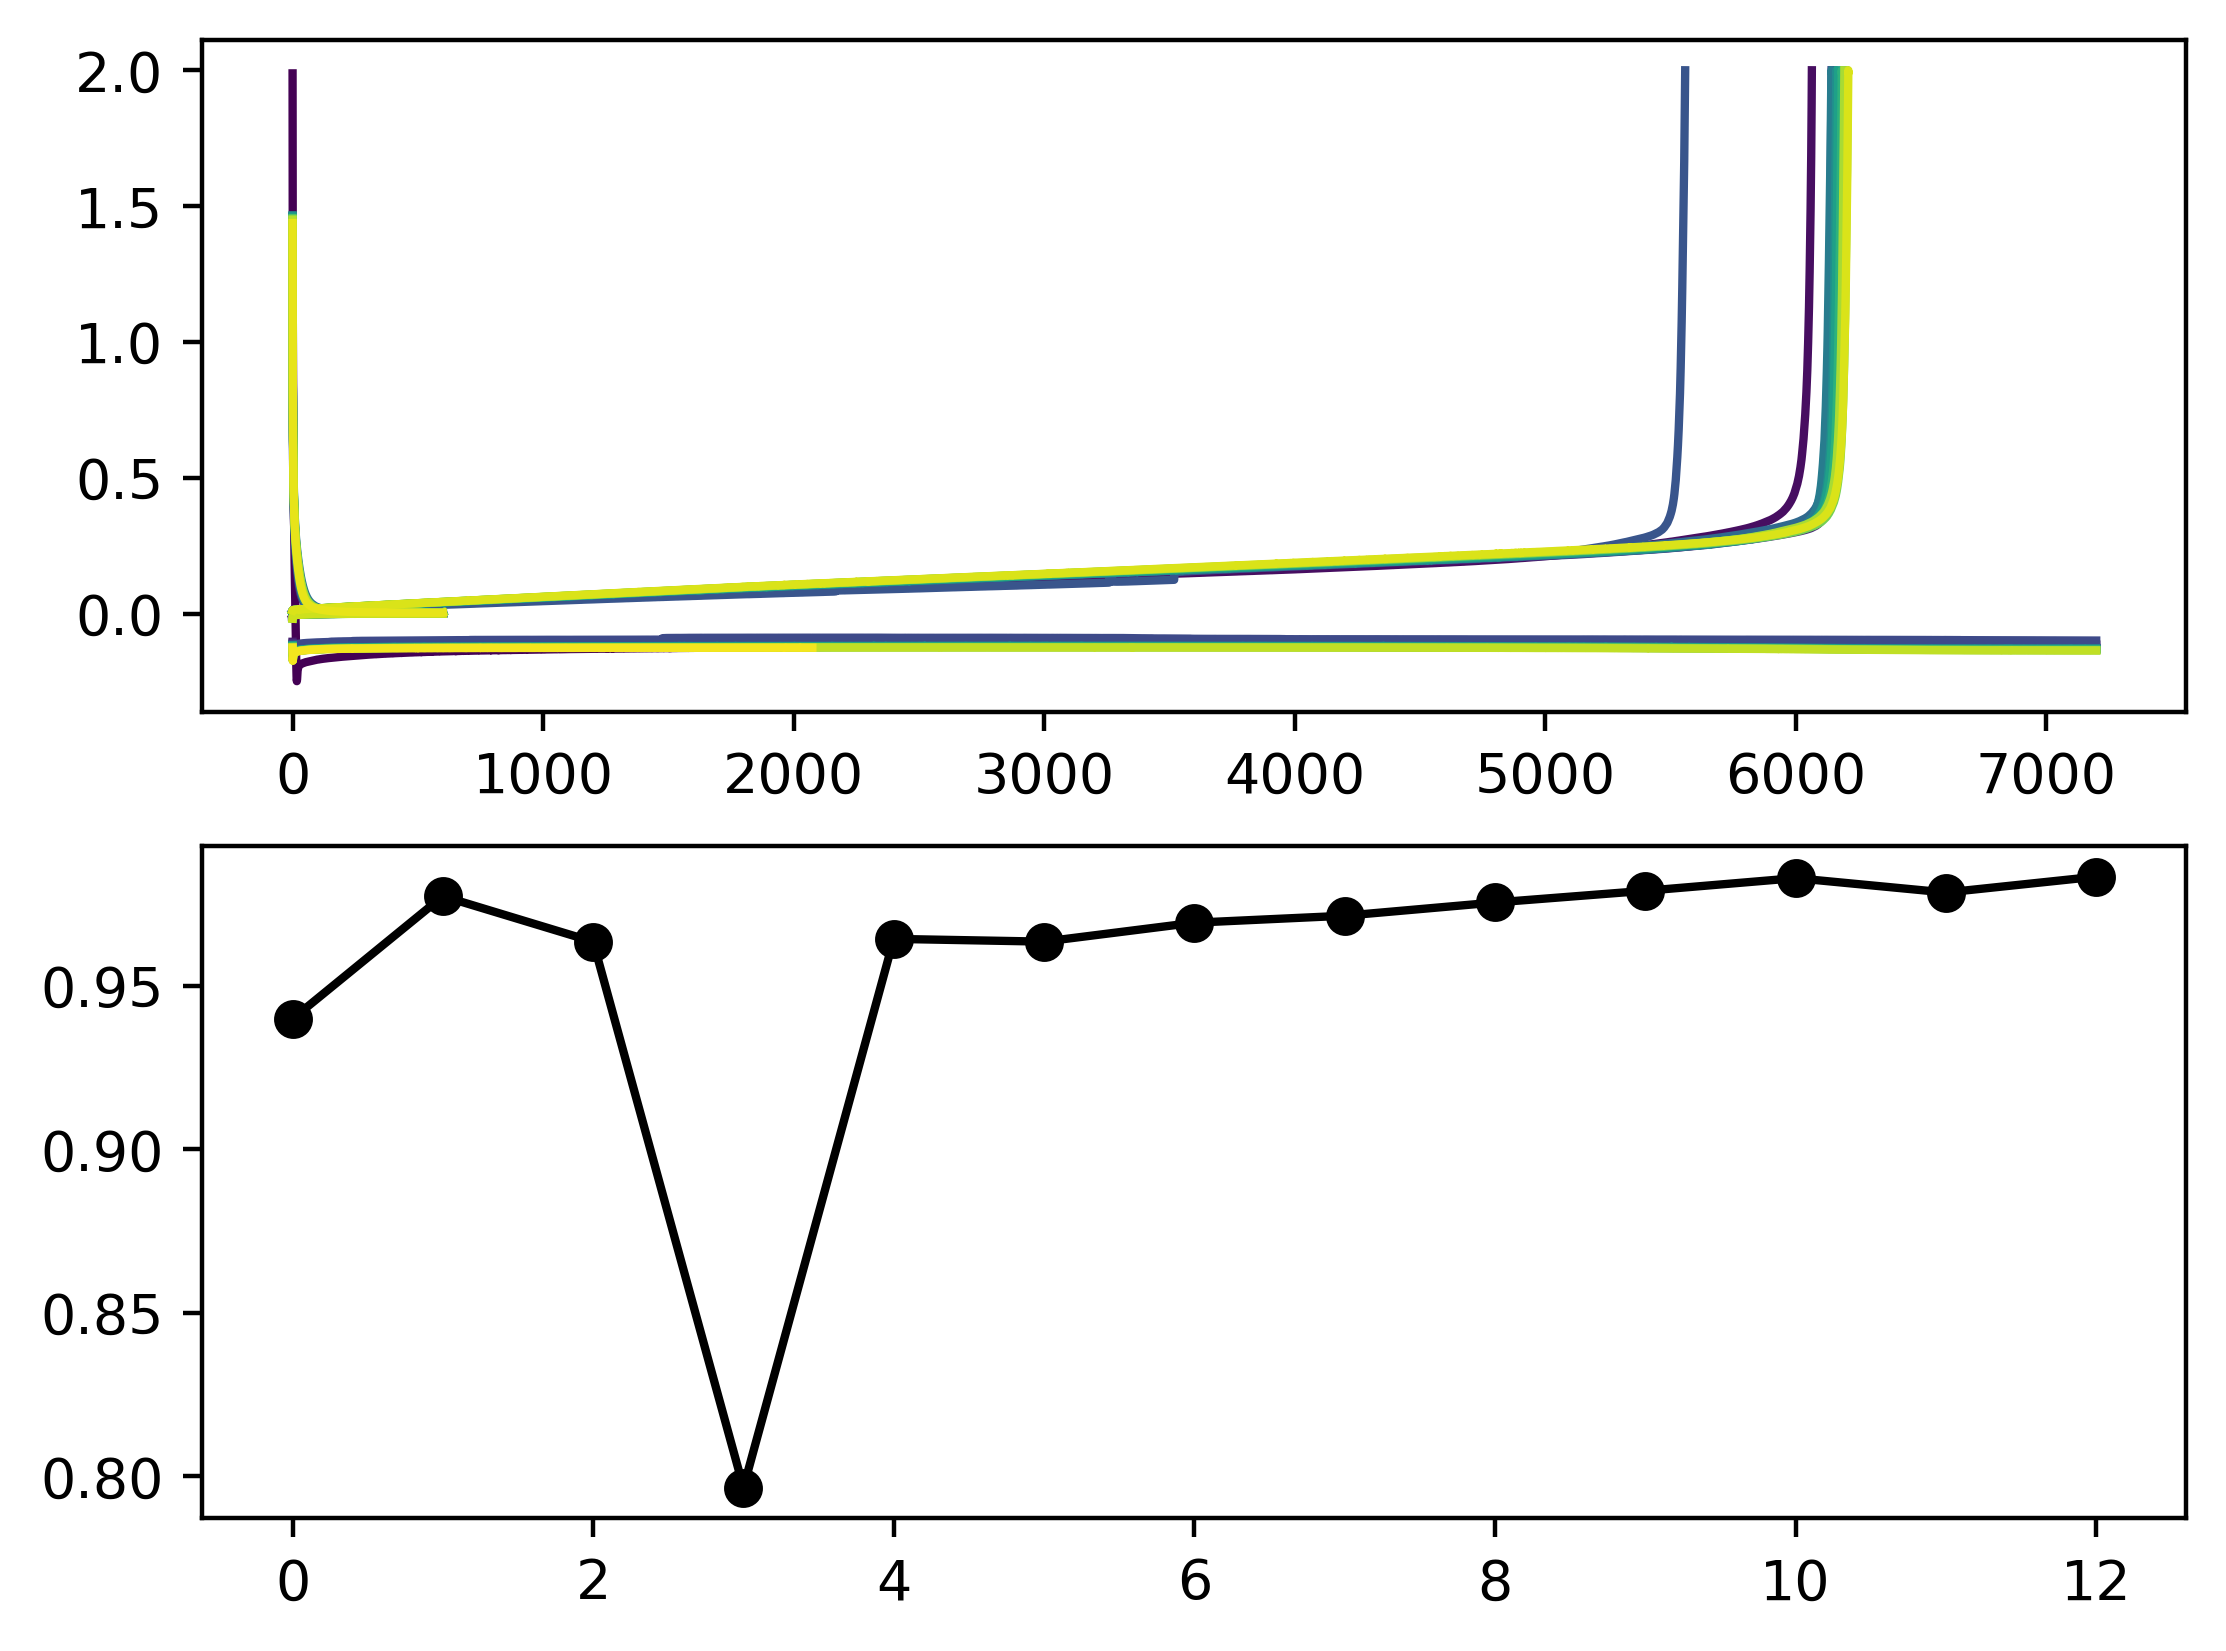

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO

file_dir = "/Users/wesleychang/OneDrive - Drexel University/Chang Lab/General/Group/Data/Biologic/"

files = ['0416_AS_C009_MG_Run_CurrentRampTest_C01.mpt']

def get_biologic(fname):
    with open(fname, 'rb') as f:
        l = f.read()
    l = l.replace(b'\xb2', b'2')
    l = l.replace(b'\xb5', b'2')
    l = l.replace(b'\xb0',b'2')
    lines = l.decode('latin-1').split('\n')
    for line in lines:
        if 'header lines' in line:
            header = line
            break
    header = int(header.strip()[-2:])
    str_data = lines[header-1:]
    str_data = '\n'.join(str_data)
    str_data = StringIO(str_data)
    data = pd.read_csv(str_data, sep='\t')
    return data

def split_data(data):
    '''
    splits raw time series data into cycles
    '''
    mask = (np.abs(np.diff(data['I/mA'])) > 0.01)
    # mask = mask & (data['I/mA'][1:] == 0)
    # mask = mask & (data['Ewe/V'][1:] < 0)
    # mask = mask & (data['I/mA'][:-1] < -0.001)
    
    mask = np.where(mask)[0] + 1

    cycle_data = np.split(data, mask)
    return cycle_data
    
'''Import files'''
for f in files:
    data = get_biologic(file_dir + f)
    print(data.keys())

'''Initialize figures'''

fig1 = plt.figure(dpi=400)
ax1 = fig1.add_subplot(211)
ax2 = fig1.add_subplot(212)
colormap = plt.get_cmap('viridis')

'''Data processing'''
data = split_data(data)
cap_plate = []
cap_strip = []
for i, d in enumerate(data):
    if d['I/mA'].iloc[0] < 0:
        cap_plate.append(np.abs(d['dQ/mA.h'].iloc[-1]))
    if d['I/mA'].iloc[0] > 0:
        cap_strip.append(d['dQ/mA.h'].iloc[-1])
    ax1.plot(d['time/s']-d['time/s'].iloc[0], d['Ewe/V'], color=colormap(i/len(data)))

CE = []
for s,p in zip(cap_strip,cap_plate):
    CE.append(s/p)

print(len(cap_plate))
ax2.plot(CE, color='k', marker='o')
plt.show()
